# DVH Prediction for Prostate Cancer using Structure Volumes

## Dr Indranil Mallick and Dr Saheli Saha, Tata Medical Center, Kolkata

Aim: To predict dose volume parameters of the rectum, bladder, PTV60 and PTV44 from the volumes of the rectum, bladder, PTV60, PTV44, and overlap of the rectal and bladder volumes with PTV60. We use regression algorithms of the scikit-learn package in python.

#### Importing Libraries

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Stop warnings from displaying within the notebook

In [32]:
import warnings
warnings.filterwarnings('ignore')

Progress bar to show progress of relatively lengthier steps

In [33]:
import progressbar

Import scikit-learn libraries for pre=processing, train-test split, regression and evaluation

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, ensemble, svm, tree
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error

#### Choosing the structure whose DVH we wish to predict

In [175]:
print('Select the structure you want to run the algorithms on:')
print('rectum, bladder, ptv60, ptv44')
organ = input('Type in the name of the structure:')

Select the structure you want to run the algorithms on:
rectum, bladder, ptv60, ptv44


Type in the name of the structure: ptv60


#### Choosing the regression algorithm
Seven different regression algorithms are used - for comparison

In [214]:
print("Select type of regression:")
print("lr: linear regression")
print("dt: decision tree")
print("rf: random forest")
print("gbr: gradient boosting regression")
print("en: ElasticNet regression")
print("svm: Support vector machine regression")
print("mlp: multilayer perceptron")
rtype = input("type in the type of regression: ")

Select type of regression:
lr: linear regression
dt: decision tree
rf: random forest
gbr: gradient boosting regression
en: ElasticNet regression
svm: Support vector machine regression
mlp: multilayer perceptron


type in the type of regression:  rf


##### Based on the selection above, the regression algorithm is initialized.
Hyperparameters for individual algorithms can be adjusted in this cell

In [215]:
if rtype =="lr":
    regr = linear_model.LinearRegression()
elif rtype =="dt":
    regr = tree.DecisionTreeRegressor(max_depth = 5)
elif rtype =="el":
    regr = linear_model.ElasticNet(random_state=0, max_iter = 10000)
elif rtype == "rf":
    regre = ensemble.RandomForestRegressor(max_depth=3, random_state=0, n_estimators = 60, max_features = 'log2')
elif rtype == "gbr":
    params = {'n_estimators': 100,
          'max_depth': 6,
          'min_samples_split': 5,
          'learning_rate': 0.3,
          'loss': 'ls'}
    regr = ensemble.GradientBoostingRegressor(**params)
elif rtype =="svm":
    regr = svm.SVR(kernel='poly', C=1, gamma='auto', coef0=1)
elif rtype=="mlp":
    MLPRegressor(hidden_layer_sizes=(6,36,6), 
                 solver='adam', 
                 activation = 'relu', 
                 batch_size='auto', 
                 learning_rate='adaptive',
                 learning_rate_init = 0.1,
                 max_iter=20000, 
                 random_state=3, 
                 verbose=False, 
                 n_iter_no_change=10)
        

##### Files with library doses are present in the current folder. Based on the structure selection, the appropriate structure DVH library csv file is opened and the feature values and dose-volume values are separated into two different dataframes.

In [216]:
fname_organ = organ + ".csv"

In [217]:
organlib = pd.read_csv(fname_organ, index_col = [0])
organ_features = organlib[['bladder_os', 'rectum_os', 'ptv60', 'ptv44', 'rectum', 'bladder']]
organlibdoses = organlib.loc[:,'0':'6200']
doselist = organlibdoses.columns.tolist()

#### Train test split
7:3 ratio with a random seed

In [218]:
xTrain, xTest, yTrain, yTest = train_test_split(organ_features, organlibdoses, test_size = 0.3, random_state = 0)

#### Standardization of features 
Standardize features by removing the mean and scaling to unit variance

In [219]:
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(xTrain)

# Apply transform to both the training set and the test set.
xTrain_ss = scaler.transform(xTrain)
xTest_ss = scaler.transform(xTest)

#### Initialize two output dataframes for the predicted dose-volumes and the regression evaluation metrics

In [220]:
predict = xTest
metrics = pd.DataFrame(columns = ['mean', 'std', 'median', 'max', 'min','mse_test', 'mae_test', 'mse_train', 'mae_train','varscore'], index = doselist)

#### Initialize progress bars for the regression, and graphing steps

In [221]:
progressreg = progressbar.ProgressBar()
progressdvh1 = progressbar.ProgressBar()
progressdvh2 = progressbar.ProgressBar()

### The regression operation
* Loops through each of the dose points (0 to 6200 cGy at 10 cgY intervals)
* Performs the regression fit and predict operations
* Adds the predicted doses to the appropriate dose column of the 'predict' dataframe
* Computes the evaluation metrics for each dose level and adds them to the 'metrics' dataframe

In [222]:
for dose in progressreg(doselist):
    #print(dose)
    metrics.loc[dose, 'mean'] = organlibdoses[dose].mean()
    metrics.loc[dose, 'std'] = organlibdoses[dose].std()
    metrics.loc[dose, 'median'] = organlibdoses[dose].median()
    metrics.loc[dose, 'max'] = organlibdoses[dose].max()
    metrics.loc[dose, 'min'] = organlibdoses[dose].min()
    regr.fit(xTrain_ss, yTrain[dose])
    y_hat_train = regr.predict(xTrain_ss)
    y_hat = regr.predict(xTest_ss)
    predict[dose] = y_hat
    metrics.loc[dose, 'mse_test'] = mean_squared_error(yTest[dose], y_hat)
    metrics.loc[dose, 'mae_test'] = median_absolute_error(yTest[dose], y_hat)
    metrics.loc[dose, 'mse_train'] = mean_squared_error(yTrain[dose], y_hat_train)
    metrics.loc[dose, 'mae_train'] = median_absolute_error(yTrain[dose], y_hat_train)
    metrics.loc[dose, 'varscore'] = r2_score(yTest[dose], y_hat)  

100% |########################################################################|


#### Transpose the actual and predicted doses to make it easier for calculations and plotting

In [223]:
predictdoses = predict.loc[:,'0':'6200']
predicted = predictdoses.transpose()
actual = yTest.transpose()

#### Create filenames based on structure and regression method for the files to be saved for each method

In [224]:
fname_actual = organ + "_actual_" + rtype + ".csv"
fname_predicted = organ + "_predicted_" + rtype + ".csv"
fname_metrics = organ + "_metrics_" + rtype + ".csv"
fname_metrics_table = organ + "_metrics_table_" + rtype + ".csv"
fname_plot1 = organ + "_dvh_" + rtype + ".png"
fname_plot2 = organ + "_dvh_mod_" + rtype + ".png"
fname_metrics_plot = organ + "_metrics_" + rtype + ".png"

In [225]:
actual.to_csv(fname_actual)
predicted.to_csv(fname_predicted)
metrics.to_csv(fname_metrics)

Create a float doselist for the plot x-axis

In [226]:
doselistn = list(map(float, doselist))

### Plot 1: Based on unedited predicted dose-volumes
Uses matplotlib subplots

100% |########################################################################|


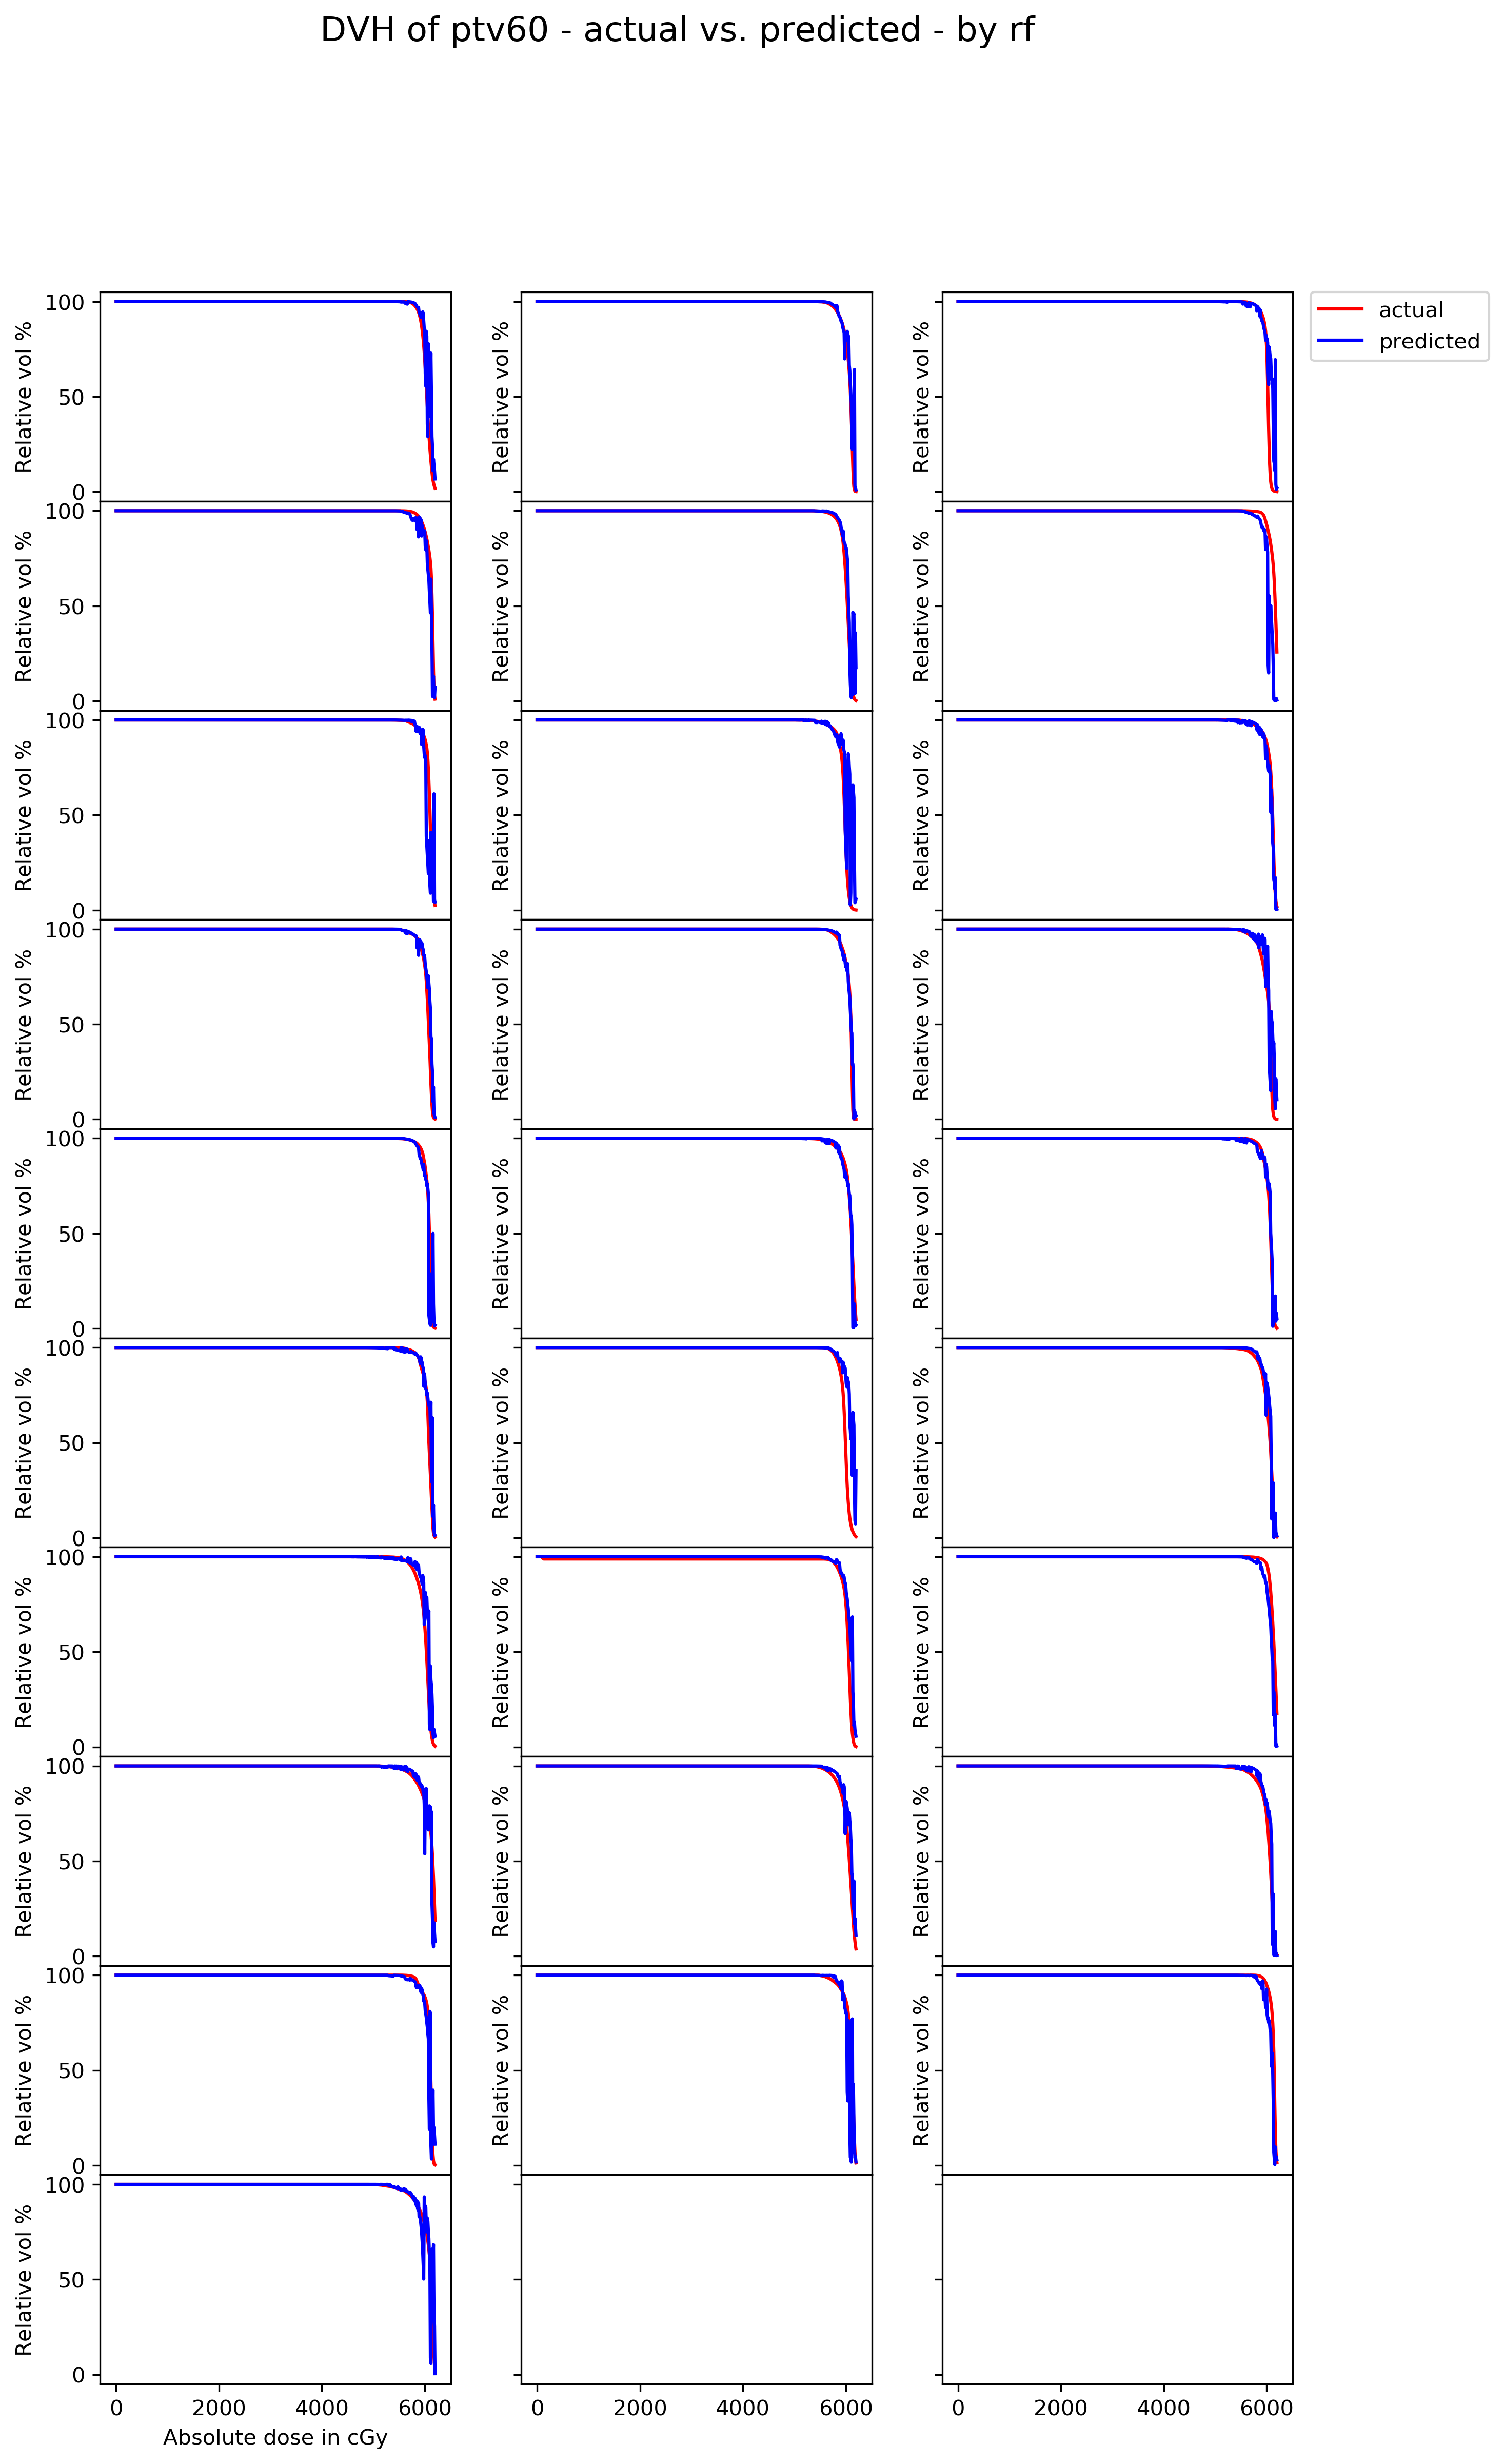

In [227]:
cases = actual.columns.tolist()
fig, axs = plt.subplots(10,3, sharex = True, sharey = True, figsize = (10,18), dpi = 300, gridspec_kw = {'hspace':0})
figtitle = "DVH of " + organ + " - actual vs. predicted - by " + rtype
fig.suptitle(figtitle, fontsize=16)
figno = 0
for case in progressdvh1(cases):
    row = figno//3
    col = figno%3
    axs[row,col].plot(doselistn, actual[case], color = 'red', label = 'actual')
    axs[row,col].plot(doselistn, predicted[case], color = 'blue', label = 'predicted')
    axs[row,col].set_xlabel("Absolute dose in cGy")
    axs[row,col].set_ylabel("Relative vol %")
    #axs[row,col].legend()
    
    figno +=1
axs[0,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)        
plt.savefig(fname_plot1)
plt.show()

#### Plot 2: Predicted volumes greater than 100% are edited to 100% before plotting

In [228]:
predicted1=predicted
for col in predicted.columns.tolist():
    predicted1[col] = predicted[col].apply(lambda x: 100.0 if x>=100 else x)

100% |########################################################################|


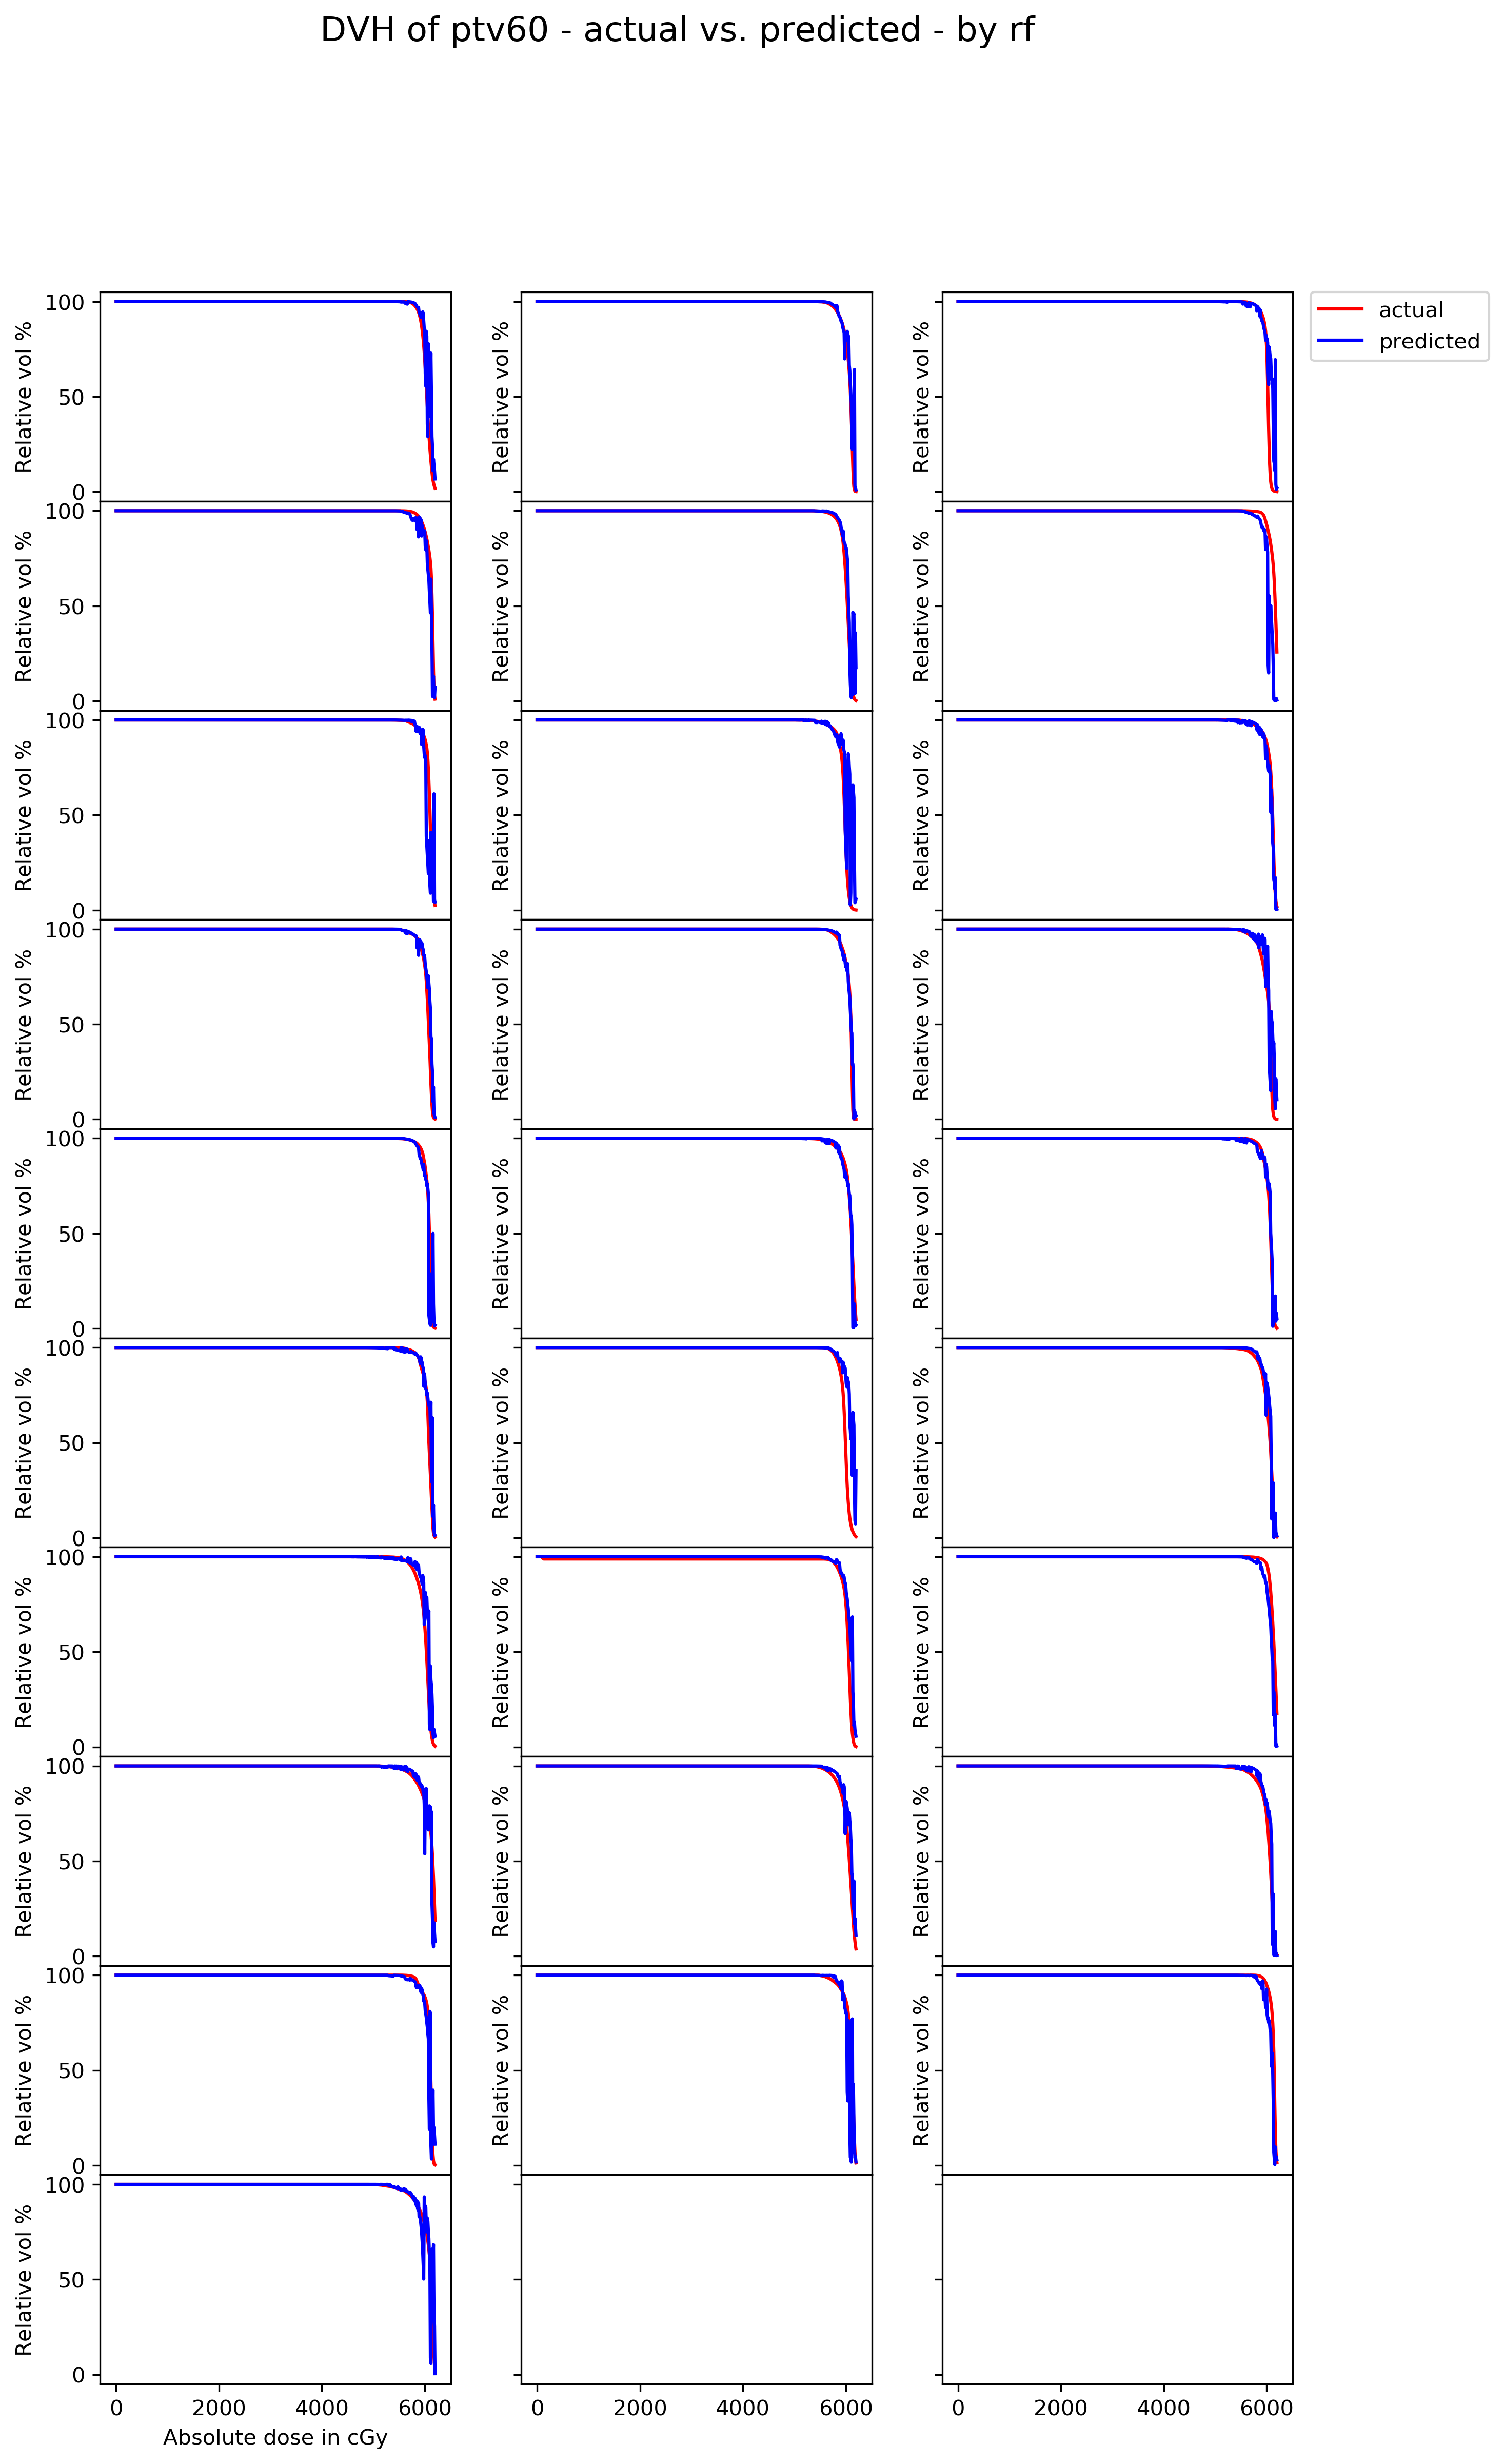

In [229]:
cases = actual.columns.tolist()
fig, axs = plt.subplots(10,3, sharex = True, sharey = True, figsize = (10,18), dpi = 300, gridspec_kw = {'hspace':0})
figtitle = "DVH of " + organ + " - actual vs. predicted - by " + rtype
fig.suptitle(figtitle, fontsize=16)
figno = 0
for case in progressdvh2(cases):
    row = figno//3
    col = figno%3
    axs[row,col].plot(doselistn, actual[case], color = 'red', label = 'actual')
    axs[row,col].plot(doselistn, predicted1[case], color = 'blue', label = 'predicted')
    axs[row,col].set_xlabel("Absolute dose in cGy")
    axs[row,col].set_ylabel("Relative vol %")
    #axs[row,col].legend()
    
    figno +=1
axs[0,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)        
plt.savefig(fname_plot2)
plt.show()

#### Plot 3: Plot of metrics

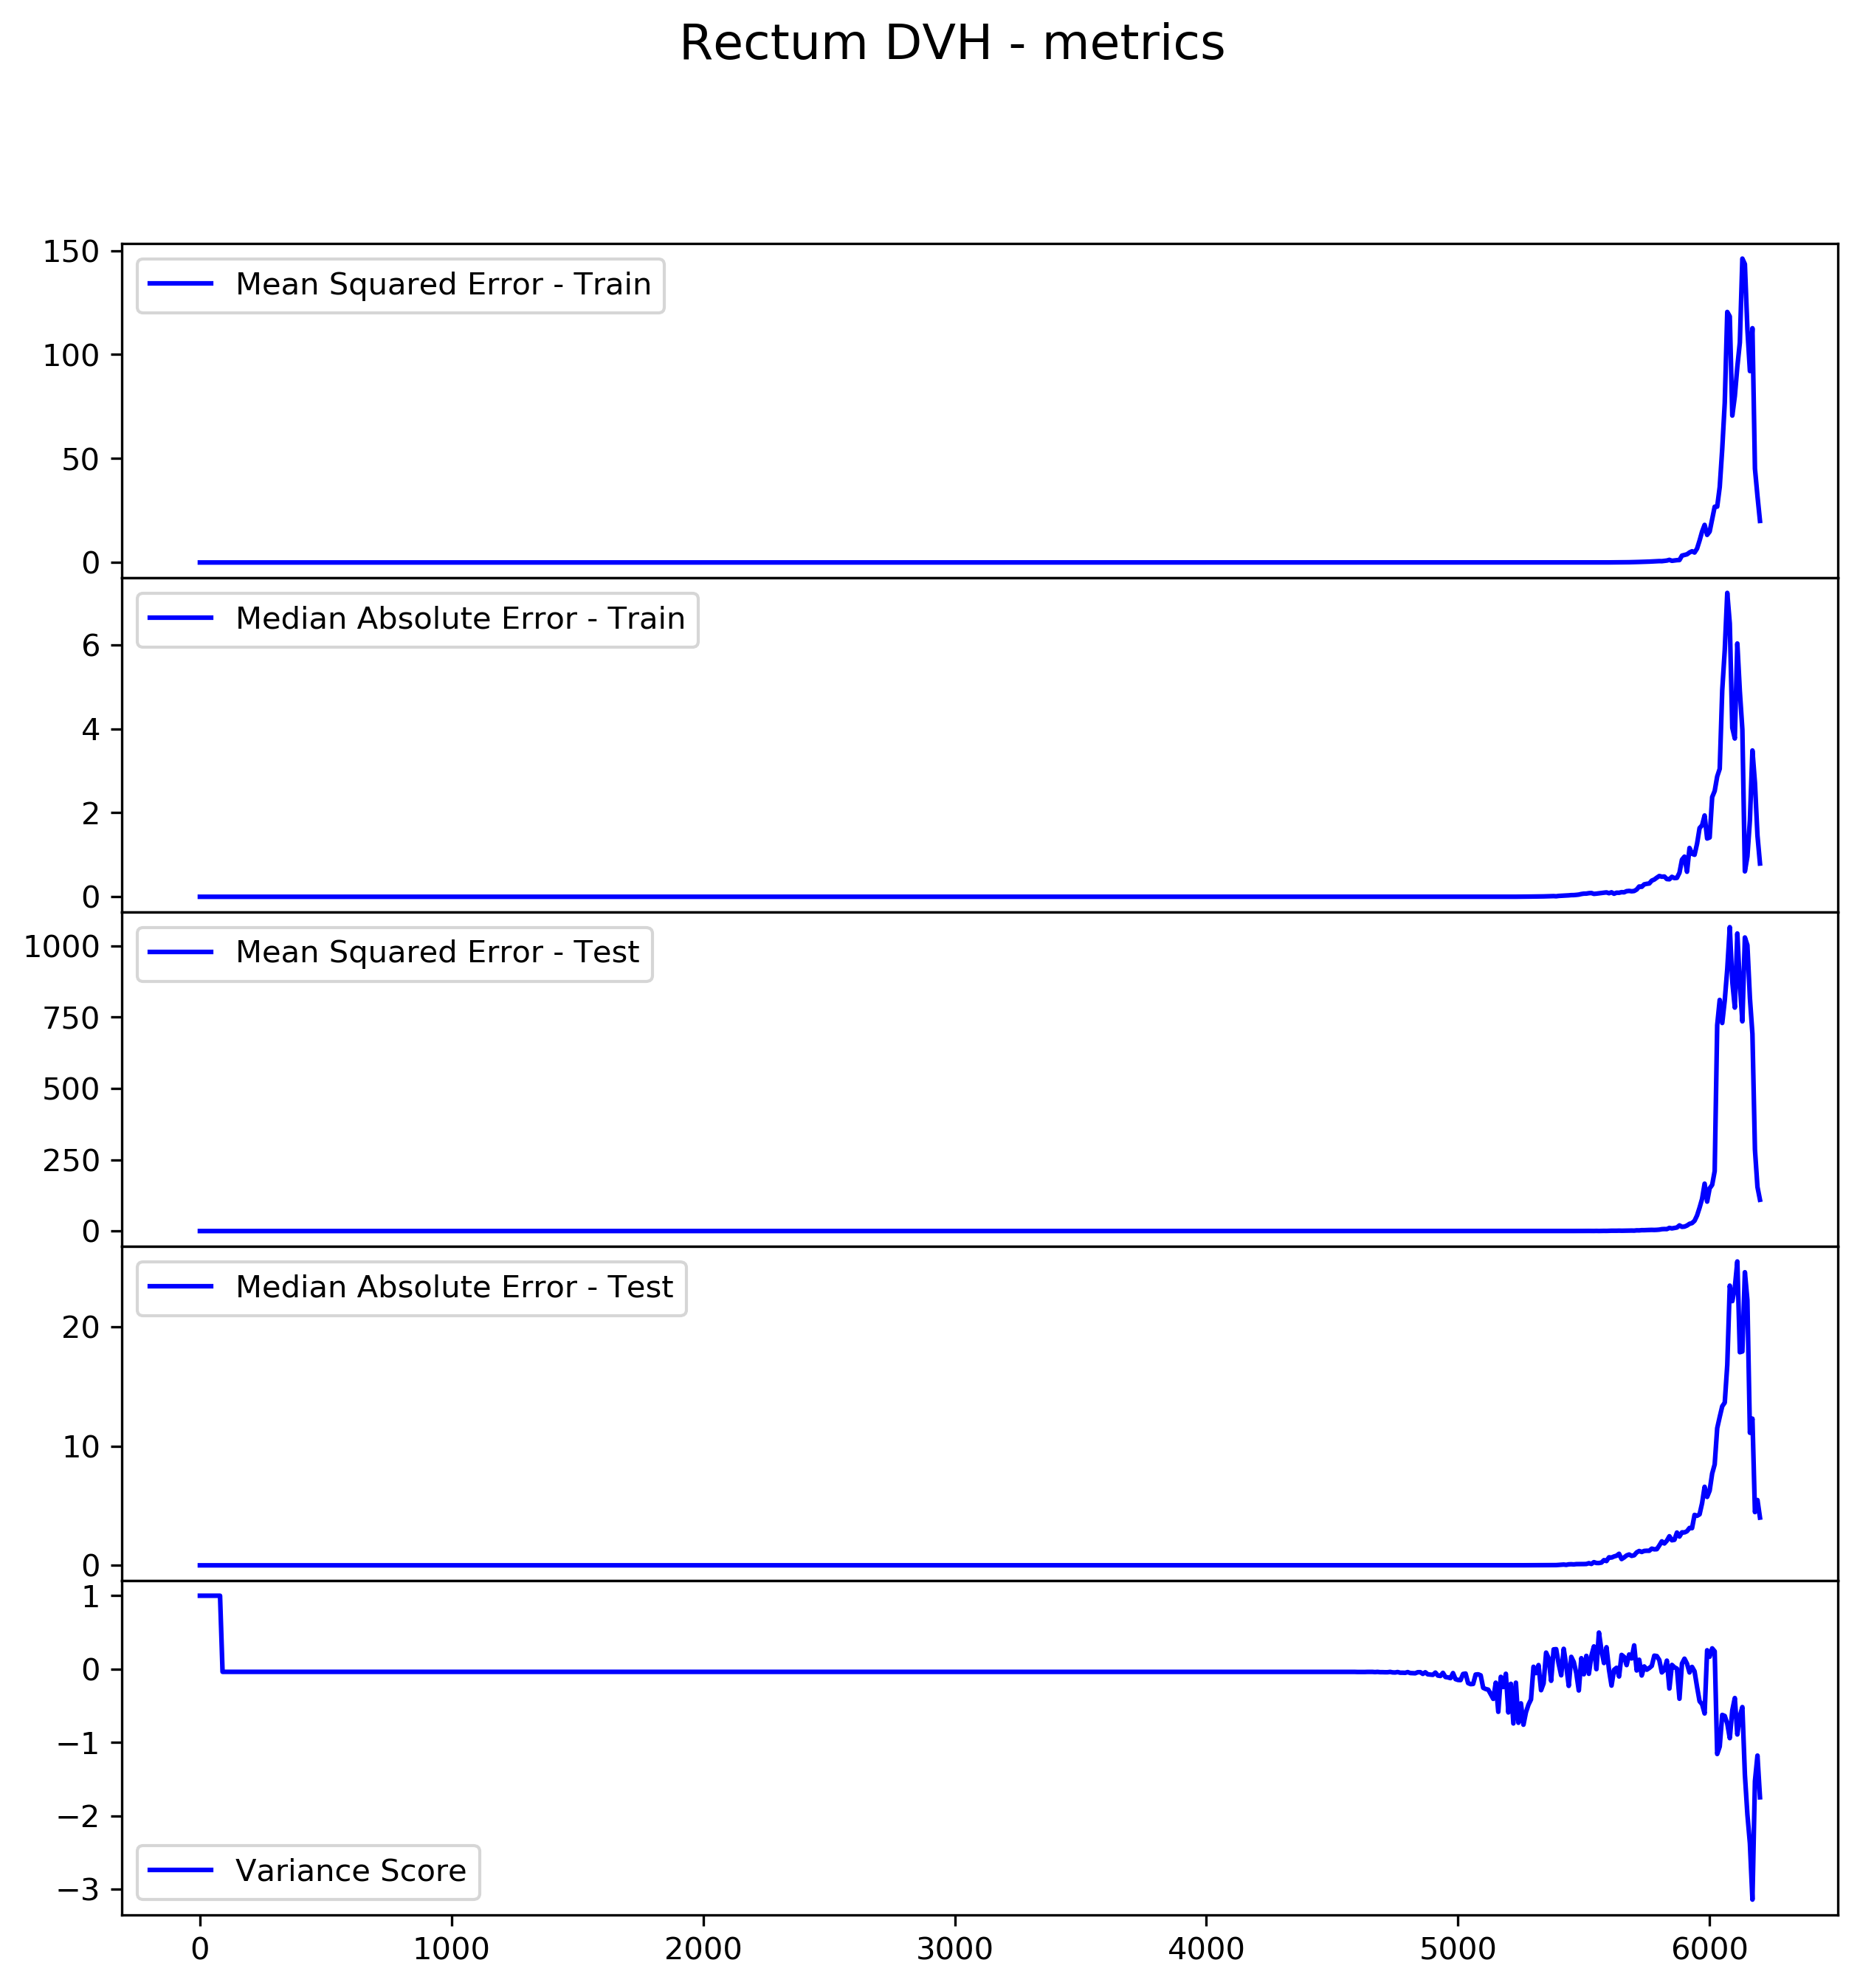

In [230]:
fig1, axs1 = plt.subplots(5, sharex = True, figsize = (10,10), dpi = 300, gridspec_kw = {'hspace':0})
figtitle2 = "Metrics of predicted DVH of" + organ + " by " + rtype
fig1.suptitle(figtitle2, fontsize=16)
axs1[0].plot(doselistn,metrics['mse_train'], color = 'blue', label = 'Mean Squared Error - Train')
axs1[0].legend()
axs1[1].plot(doselistn,metrics['mae_train'], color = 'blue', label = 'Median Absolute Error - Train')
axs1[1].legend()
axs1[2].plot(doselistn,metrics['mse_test'], color = 'blue', label = 'Mean Squared Error - Test')
axs1[2].legend()
axs1[3].plot(doselistn,metrics['mae_test'], color = 'blue', label = 'Median Absolute Error - Test')
axs1[3].legend()
axs1[4].plot(doselistn,metrics['varscore'], color = 'blue', label = 'Variance Score')
axs1[4].legend()

plt.savefig(fname_metrics_plot)
plt.show()

#### Create and save a summary metrics table
Evaluate metrics for all doses, and specific dose ranges

In [231]:
metrics1 = metrics.loc['0':'1990']
metrics2 = metrics.loc['2000':'3990']
metrics3 = metrics.loc['4000':'6200']
metrics_table = pd.DataFrame(columns = ['all','0-1990', '2000-3990', '4000-6200'])
paramlist = ['mse_train','mse_test', 'mae_train', 'mae_test', 'varscore']
for param in paramlist:
    metrics_table.loc[param,'all'] = metrics[param].mean()
    metrics_table.loc[param,'0-1990'] = metrics1[param].mean()
    metrics_table.loc[param,'2000-3990'] = metrics2[param].mean()
    metrics_table.loc[param,'4000-6200'] = metrics3[param].mean()
metrics_table

,all,0-1990,2000-3990,4000-6200
mse_train,2.66143,0,0,7.4785
mse_test,23.8203,0.0460753,0.0488893,66.8481
mae_train,0.152134,0,0,0.427489
mae_test,0.631015,0,0,1.77312
varscore,-0.0616027,0.00962963,-0.037037,-0.148298


In [232]:
metrics_table.to_csv(fname_metrics_table)